# Face Generation

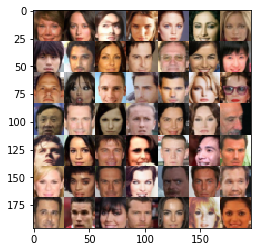

In [5]:
import os
from glob import glob
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline

celeb_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:50], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

In [14]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate

def leaky_relu(x, alpha=0.1, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        L1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        L1 = leaky_relu(L1)
        # 14x14x64

        L2 = tf.layers.conv2d(L1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        L2 = tf.layers.batch_normalization(L2, training=True)
        L2 = leaky_relu(L2)
        # 7x7x128

        L3 = tf.layers.conv2d(L2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        L3 = tf.layers.batch_normalization(L3, training=True)
        L3 = leaky_relu(L3)
        # 4x4x256

        L4 = tf.layers.conv2d(L3, 512, 3, strides=2, padding='same')
        L4 = tf.layers.batch_normalization(L4, training=True)
        L4 = leaky_relu(L4)
        # 2x2x512

        # flat = tf.reshape(L3, (-1, 4*4*256))
        flat   = tf.contrib.layers.flatten(L4)
        logits = tf.layers.dense(flat, 1)
        out    = tf.sigmoid(logits)

    return out, logits

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected
        L1 = tf.layers.dense(z, 2*2*512)
        
        # Start the convolution
        L1 = tf.reshape(L1, (-1, 2, 2, 512))
        L1 = tf.layers.batch_normalization(L1, training=is_train)
        L1 = leaky_relu(L1)
        # 2x2x512

        L2 = tf.layers.conv2d_transpose(L1, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        L2 = tf.layers.batch_normalization(L2, training=is_train)
        L2 = leaky_relu(L2)
        # 4x4x256

        L3 = tf.layers.conv2d_transpose(L2, 128, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        L3 = tf.layers.batch_normalization(L3, training=is_train)
        L3 = leaky_relu(L3)
        # 7x7x128
    
        L4 = tf.layers.conv2d_transpose(L3, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        L4 = tf.layers.batch_normalization(L4, training=is_train)
        L4 = leaky_relu(L4)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(L4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out    = tf.tanh(logits) 
        
    return out

def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates  = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt

## Neural Network

In [15]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Set image dimensions
    _, image_width, image_height, image_channels = data_shape
    # Set model inputs
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    # Set model loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # Set model optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps    = 0    
    print_at = 50
    show_at  = 100
    
    saver    = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: sample_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: sample_z, learn_rate: learning_rate}) 
            
                                
                if steps % print_at == 0:
                    train_loss_d = d_loss.eval({input_z: sample_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_at == 0:
                    show_generator_output(sess, 30, input_z, image_channels, data_image_mode)    

Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 6.7911
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 3.0951


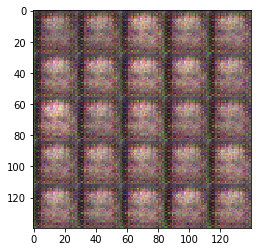

Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.2824
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.6990


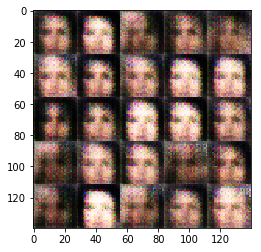

Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.6929
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.7508


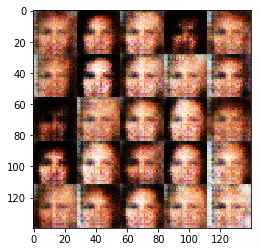

Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.8674
Epoch 1/1... Discriminator Loss: 3.4551... Generator Loss: 9.6897


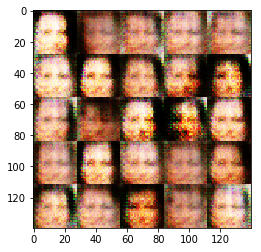

Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.8385
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.0709


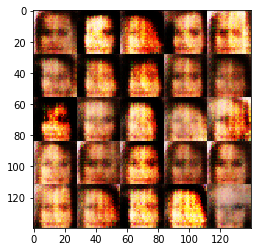

Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 2.1518
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.1671


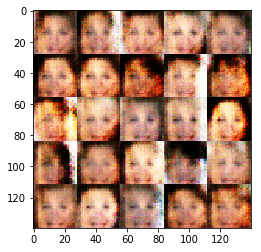

Epoch 1/1... Discriminator Loss: 0.5276... Generator Loss: 2.3582
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.2813


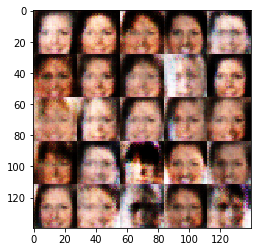

Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.7371


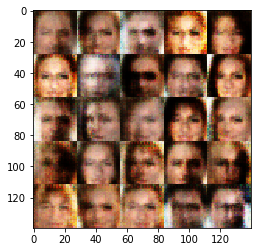

Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 1.5396
Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 3.0293


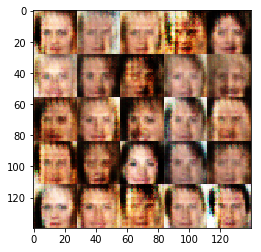

Epoch 1/1... Discriminator Loss: 0.4926... Generator Loss: 3.1369
Epoch 1/1... Discriminator Loss: 0.5637... Generator Loss: 2.1190


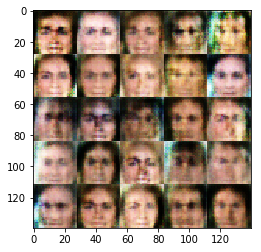

Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 3.9539
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.9029


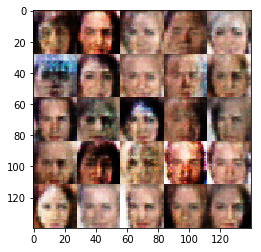

Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 3.4952
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 0.9729


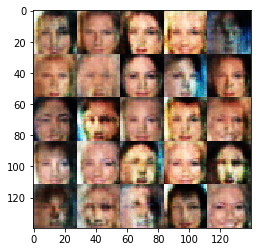

Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 2.1317
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.9571


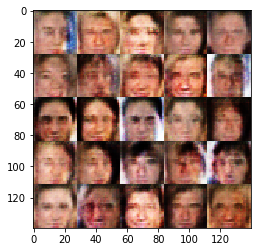

Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 2.2530
Epoch 1/1... Discriminator Loss: 0.7505... Generator Loss: 1.2816


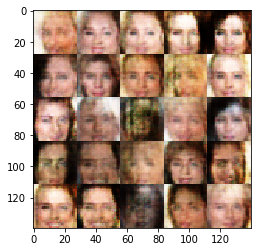

Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.3836
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.9164


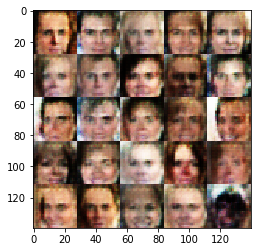

Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.7884
Epoch 1/1... Discriminator Loss: 0.4582... Generator Loss: 3.5267


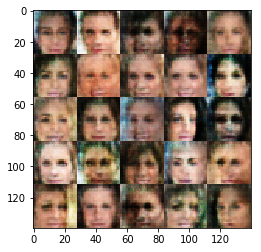

Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.8324
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.8555


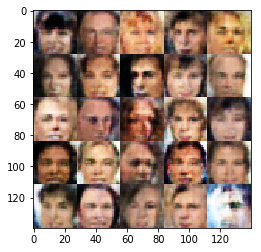

Epoch 1/1... Discriminator Loss: 0.5134... Generator Loss: 2.3322
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 1.2542


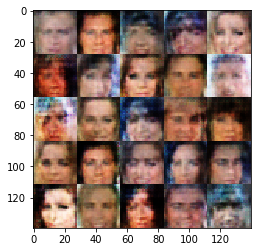

Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.3966


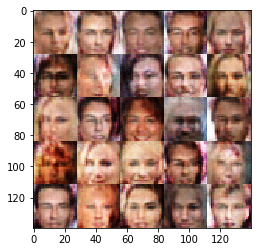

Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 0.4981... Generator Loss: 2.8240


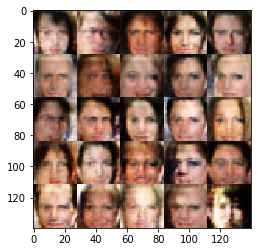

Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 1.7603
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 3.3305


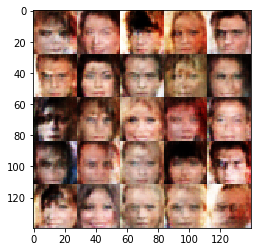

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 7.0375
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.2969


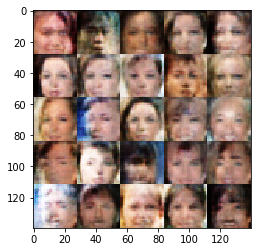

Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 2.1581
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.7774


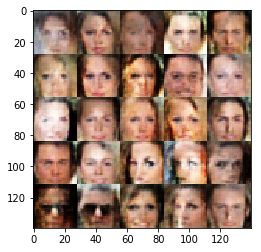

Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 1.8733


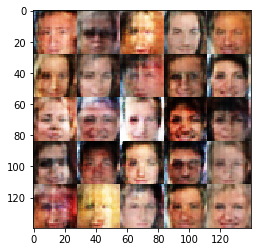

Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.1217


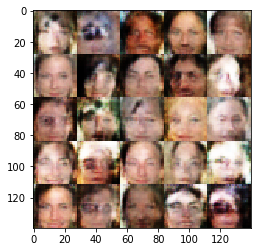

Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 3.6108
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 2.1271


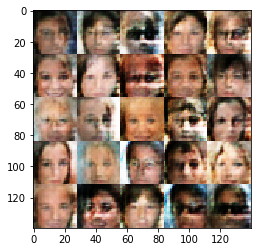

Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 1.6892
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.8304


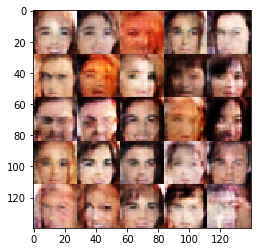

Epoch 1/1... Discriminator Loss: 0.6147... Generator Loss: 2.6060
Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.3042


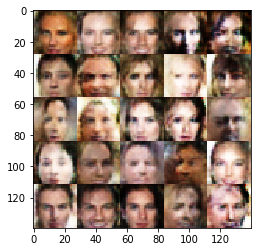

Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.8827


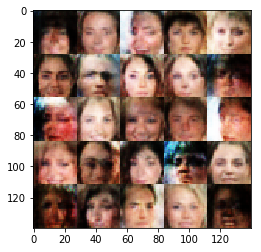

Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 2.3240
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 4.4233


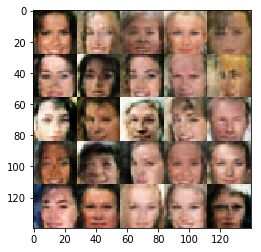

Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 3.0891
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.4511


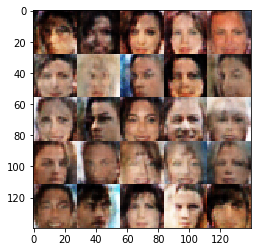

Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 2.2737


In [16]:
# Run GAN on celebrity images to generate new and unique faces
batch_size = 64 
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

epochs = 1

tf.reset_default_graph()
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)